In [21]:
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
import torch.nn.functional as F

# Word2Vec Tutorial

This notebook demonstrates how to use Word2Vec for word embedding generation, visualization, and analysis.

## Introduction
Word2Vec is a neural network-based model that converts words into dense vectors of fixed size, capturing semantic relationships between words. These vectors are used in various NLP tasks, such as text classification, sentiment analysis, and more.

### Key Concepts
- **Continuous Bag of Words (CBOW):** Predicts a word based on its context.
- **Skip-Gram:** Predicts the context based on a given word.

Both methods aim to create word embeddings that preserve semantic relationships.

### Step 1: Prepare the Data

In [22]:
corpus = [
    "machine learning models are powerful",
    "word embeddings like word2vec are useful",
    "deep learning uses neural networks",
    "neural networks are a key component of deep learning",
    "word2vec captures word relationships in dense vectors"
]

In [23]:
tokenized_corpus = [sentence.lower().split() for sentence in corpus]

### Step 2: Train a Word2Vec Model

In [24]:
model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=100,
    window=3,
    min_count=1,
    sg=1,
    epochs=100
)

### Step 3: Visualize Word Embeddings

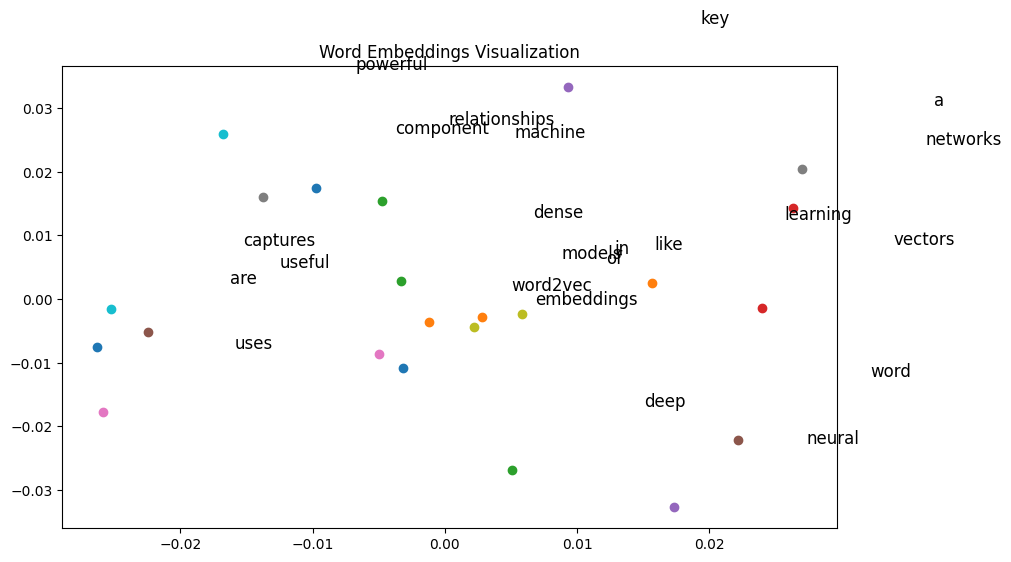

In [25]:
words = list(model.wv.key_to_index.keys())
word_vectors = model.wv[words]

pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

plt.figure(figsize=(10, 6))
for i, word in enumerate(words):
    plt.scatter(word_vectors_2d[i, 0], word_vectors_2d[i, 1])
    plt.text(word_vectors_2d[i, 0] + 0.01, word_vectors_2d[i, 1] + 0.01, word, fontsize=12)
plt.title("Word Embeddings Visualization")
plt.show()

### Step 4: Analyze Word Relationships

In [26]:
print("Most similar to 'deep':", model.wv.most_similar('deep'))
print("Similarity between 'deep' and 'learning':", model.wv.similarity('deep', 'learning'))

Most similar to 'deep': [('of', 0.2047886848449707), ('in', 0.19691377878189087), ('neural', 0.18768168985843658), ('like', 0.1722959280014038), ('word2vec', 0.17104966938495636), ('embeddings', 0.16552136838436127), ('word', 0.08989265561103821), ('dense', 0.06932149082422256), ('a', 0.023590795695781708), ('component', 0.011019394733011723)]
Similarity between 'deep' and 'learning': -0.005835863


### Step 5: Save and Load the Model

In [27]:
# model.save("word2vec.model")

# loaded_model = Word2Vec.load("word2vec.model")

### Conclusion
Word2Vec is a powerful tool for learning word embeddings. It captures semantic meanings and relationships, enabling its use in various NLP tasks. This notebook demonstrates how to train, visualize, and analyze word embeddings using Word2Vec.

In [28]:
class Word2VecCBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecCBOW, self).__init__()
        # Initialize embedding layer to map words to dense vectors
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Initialize linear layer to map embeddings to vocabulary space
        self.linear = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, context_idxs):
        # Look up embeddings for context words and calculate their mean
        embeddings = self.embeddings(context_idxs).mean(dim=0)
        # Apply the linear layer to map mean embeddings to vocabulary space
        # we're using the context, to predict all words in the vocabulary. The model will try to learn to give the highest 
        # probability to the word we want to predict.
        output = self.linear(embeddings)
        return output  

In [29]:
def train_word2vec_cbow(model, tokenized_corpus, word_to_idx, idx_to_word, epochs=10, learning_rate=0.01, window_size=1):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0  
        for sentence in tokenized_corpus:
            # Convert the sentence into indices based on word_to_idx mapping
            sentence_tensor = torch.tensor([word_to_idx[word] for word in sentence], dtype=torch.long)
            
            for target_idx in range(len(sentence)):
                # idxs from 0 to the len of the sentence
                # Define the range of context words around the target word
                # when window_size is 1, we get one word on the left and one word on the right
                context_range = range(max(0, target_idx - window_size), min(len(sentence), target_idx + window_size + 1))
                # Collect indices of context words, excluding the target word
                context_idxs = [sentence_tensor[i] for i in context_range if i != target_idx]
                
                # if len(context_idxs) == 1:
                #     print('---one---')
                #     item = context_idxs[0].item()
                #     print(idx_to_word[item])
                # else:
                #     print(context_idxs)
                        
                
                if not context_idxs:
                    continue  # Skip if there are no valid context words
                
                # Convert context indices to tensor
                context_tensor = torch.tensor(context_idxs, dtype=torch.long).to(device)
                # Get the target word index safely
                target_tensor = sentence_tensor[target_idx].clone().detach().to(device)
                
                optimizer.zero_grad()
                
                logits = model(context_tensor)
                
                loss = loss_function(logits.view(1, -1), target_tensor.view(-1))
                total_loss += loss.item()  # Accumulate loss
                
                loss.backward()
                optimizer.step()
        
        # Print total loss for the epoch
        if epoch % 100 == 0: print(f"Epoch {epoch + 1}, Loss: {total_loss}")

In [30]:
corpus = [
    "apples and bananas are popular fruits",
    "oranges and mangoes are sweet and tasty",
    "computers process data and execute instructions",
    "laptops and desktops are types of computers",
    "fruits are healthy and rich in vitamins",
    "modern computers are fast and efficient",
    "bananas and mangoes are tropical fruits",
    "computers use binary code to represent information",
    "apples and oranges are common fruits in the market",
    "desktops are more powerful than most laptops"
]

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
# Tokenize corpus into lists of words
tokenized_corpus = [sentence.lower().split() for sentence in corpus]
# Create vocabulary and mappings
vocab = set(word for sentence in tokenized_corpus for word in sentence)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

In [33]:
# Initialize CBOW model
embedding_dim = 100  # Define size of word embeddings
model = Word2VecCBOW(len(vocab), embedding_dim).to(device)

In [34]:
%time train_word2vec_cbow(model, tokenized_corpus, word_to_idx, idx_to_word, epochs=1000, learning_rate=0.01, window_size=1)

Epoch 1, Loss: 254.51505303382874
Epoch 101, Loss: 42.908654554747045
Epoch 201, Loss: 40.51049824967049


KeyboardInterrupt: 

In [ ]:
word = "apples"
word_idx = torch.tensor([word_to_idx[word]], dtype=torch.long).to(device)
embedding = model.embeddings(word_idx).detach().cpu().numpy()  # Move to CPU before converting to NumPy
print(f"Embedding for '{word}': {embedding}")


In [ ]:
def cosine_similarity(vec1, vec2):
    dot_product = torch.dot(vec1, vec2)
    magnitude1 = torch.norm(vec1)
    magnitude2 = torch.norm(vec2)
    
    return dot_product / (magnitude1 * magnitude2)

In [ ]:
def find_similarity(word1, word2):
    word1_idx = torch.tensor([word_to_idx[word1]], dtype=torch.long).to(device)
    embds1 = model.embeddings(word1_idx).detach()

    word2_idx = torch.tensor([word_to_idx[word2]], dtype=torch.long).to(device)
    embds2 = model.embeddings(word2_idx).detach()

    return cosine_similarity(embds1.squeeze(), embds2.squeeze())

In [ ]:
find_similarity('oranges', 'laptops')

In [ ]:
find_similarity('oranges', 'bananas')

In [ ]:
find_similarity('apples', 'bananas')

# Exericse

1. Build word embeddings out of the IMDB dataset
2. Calculate a positive word that appears most in the positive reviews. Do the same for negative.
3. Use the embedding model you build to build embeddings for the positive/negative words you found, calculate the cosine similarity between a review and each positive/negative embedding. Use the closest one to classify the review